In this notebbok, we prove that LSTM fail into capturing long memory in multivariate time series. 

Then, we applied the two complementary tests detailed in the paper *A Statistical Investigation of Long Memory in Language and Music* by Greaves-Tunnell, Alexander and Harchaoui, Zaid.

The two tests consists into checking the GSE statistics of the long memory vector d in the last hidden layer of the trained LSTM. 

The difference between the two tests: the first test consists into training the LSTM on a Fractionnaly differenced WN while the second test consists into training the LSTM on a WN

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from _varfima import sim_VARFIMA, sim_FD

# Test 1: Integration of Fractionnaly Differenced WN

##### Generation of a random Fractionally Differenced White Noise

In [ ]:
# First let's generate a random long memory paramater vector (d)

np.random.seed(42)
k= 200 #number of time series 
d_min, d_max = 0.05, 0.45  # to have a long memory vector parameter (d in ]0,0.5[**p)
d = torch.tensor(np.random.uniform(d_min, d_max, size=k), dtype=torch.float32)

#Then let's generated a fractionnally differenced white noise based on the generated d vector, of length T
T=2**16 #same length as in the paper
FD_seq, _ = sim_FD(T=2**16, k=200, d=d)

### Let's build a LSTM with two layers for multivariate time series prediction

In [6]:
#Let's build the LSTM model for time series prediction

class LSTMPredictor(nn.Module):
    """LSTM for time series prediction"""
    
    def __init__(self, input_size, hidden_size=64, num_layers=2, 
                 dropout=0.2, forecast_horizon=1):
        """
        Args:
            input_size: Number of features (k variables)
            hidden_size: Size of the hidden state
            num_layers: Number of layers in the LSTM
            dropout: Dropout rate between LSTM layers
            forecast_horizon: Number of time steps to predict
        """
        super(LSTMPredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        
        # Couche LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True  # (batch, seq, feature)
        )
        
        # Couche fully connected pour la prédiction
        self.fc = nn.Linear(hidden_size, input_size * forecast_horizon)
        
        self.input_size = input_size
        
    def forward(self, x):
        """
        Args:
            x: (batch, seq_length, input_size)
        Returns:
            predictions: (batch, forecast_horizon, input_size)
        """
        batch_size = x.size(0)
        
        # LSTM forward
        # lstm_out: (batch, seq_length, hidden_size)
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Prendre la dernière sortie temporelle
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)
        
        # Prédiction
        predictions = self.fc(last_output)  # (batch, input_size*forecast_horizon)
        
        # Reshape pour séparer forecast_horizon et input_size
        predictions = predictions.view(batch_size, self.forecast_horizon, 
                                      self.input_size)
        
        return predictions

k=200

#Let's load the built LSTM model of two layers adapted to our multivariate time series of size k=200
lstm_model = LSTMPredictor(
    input_size=k,           
    hidden_size=64,        
    dropout=0.2,           
    forecast_horizon=1) 

##### Data preparation

In [7]:
class VARFIMADataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length=50, forecast_horizon=1):
        self.data = data.T  # (T, k)
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        
    def __len__(self):
        return len(self.data) - self.seq_length - self.forecast_horizon + 1
    
    def __getitem__(self, idx):
        # Input: [idx : idx+seq_length]
        X = self.data[idx:idx+self.seq_length]
        
        # Target: [idx+seq_length : idx+seq_length+forecast_horizon]
        y = self.data[idx+self.seq_length:
                      idx+self.seq_length+self.forecast_horizon]
        
        return X.float(), y.float()

In [8]:
#Let's prepare the dataset of training and validation
dataset = VARFIMADataset(FD_seq, seq_length=50, forecast_horizon=1)
X_test, y_test = dataset[0]  # Doit fonctionner


# Split train/validation 
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

# DataLoaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False
)

print(f" Prepared dataset:")
print(f"  - Train samples: {len(train_dataset)}")
print(f"  - Val samples: {len(val_dataset)}")
print(f"  - Batch size: {batch_size}")

 Prepared dataset:
  - Train samples: 52388
  - Val samples: 13098
  - Batch size: 32


##### Data Training

Entraînement sur cpu
Epoch [5/50] Train Loss: nan | Val Loss: nan
Epoch [10/50] Train Loss: nan | Val Loss: nan
Epoch [15/50] Train Loss: nan | Val Loss: nan
Epoch [20/50] Train Loss: nan | Val Loss: nan
Epoch [25/50] Train Loss: nan | Val Loss: nan
Epoch [30/50] Train Loss: nan | Val Loss: nan
Epoch [35/50] Train Loss: nan | Val Loss: nan
Epoch [40/50] Train Loss: nan | Val Loss: nan
Epoch [45/50] Train Loss: nan | Val Loss: nan
Epoch [50/50] Train Loss: nan | Val Loss: nan
✓ Entraînement terminé!


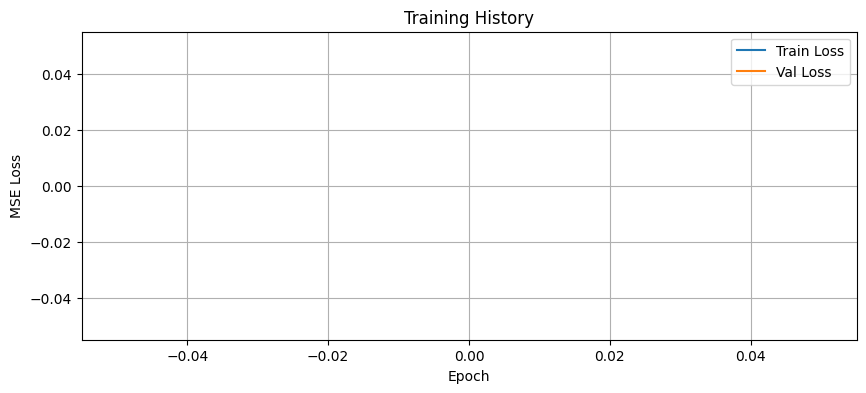

✓ Modèle sauvegardé: lstm_varfima_model.pth


In [103]:
#Let's train the LSTM on the generated data using a ADAM optimizer and MSE loss

# Configuration 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = lstm_model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5) #automatic learning rate adjustment

num_epochs = 50 #50 iterations

# Historique des pertes
train_losses = []
val_losses = []

print(f"Entraînement sur {device}")
print("=" * 50)

for epoch in range(num_epochs):
    # === TRAINING ===
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # === VALIDATION ===
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Affichage
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}")

print("=" * 50)
print("✓ Entraînement terminé")

# Visualisation of loss 
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training History')
plt.grid(True)
plt.show()

# Let's save the trained model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_losses[-1],
    'val_loss': val_losses[-1],
}, 'lstm_varfima_model.pth')

print("✓ Modèle sauvegardé: lstm_varfima_model.pth")

#### Let's verify the long memory property in the LSTM trained

In [9]:

# Charger le modèle entrainé 
model = LSTMPredictor(
    input_size=k,           
    hidden_size=64,        
    dropout=0.2,           
    forecast_horizon=1) 
model.load_state_dict(torch.load('lstm_varfima_model.pth')["model_state_dict"])
model.eval()

# Extraire les sorties LSTM pour tous les batchs
def extract_lstm_outputs_from_loader(model, train_loader):
    """
    Extrait les sorties du LSTM pour toutes les données du train_loader
    """
    all_lstm_outputs = []
    
    with torch.no_grad():
        for batch_X, batch_y in train_loader:
            # batch_X shape: (batch_size, seq_len, input_size)
            h0 = torch.zeros(model.num_layers, batch_X.size(0), model.hidden_size)
            c0 = torch.zeros(model.num_layers, batch_X.size(0), model.hidden_size)
            
            # Obtenir les sorties LSTM
            lstm_out, _ = model.lstm(batch_X, (h0, c0))
            
            # lstm_out shape: (batch_size, seq_len, hidden_size)
            all_lstm_outputs.append(lstm_out.numpy())
    
    # Concaténer tous les batchs
    all_outputs = np.concatenate(all_lstm_outputs, axis=0)  # (total_samples, seq_len, hidden_size)
    
    return all_outputs

# Extraire les sorties
lstm_outputs = extract_lstm_outputs_from_loader(model, train_loader)
print(f"Shape des sorties LSTM: {lstm_outputs.shape}")  # (n_samples, seq_len, hidden_size)

#  Créer une séquence temporelle à partir des sorties: Prendre toutes les séquences et les concaténer temporellement
# Chaque neurone caché devient une longue série temporelle
seq_concatenated = lstm_outputs.transpose(2, 0, 1).reshape(lstm_outputs.shape[2], -1)
print(f"Shape pour analyse: {seq_concatenated.shape}")  # (hidden_size, n_samples * seq_len)

Shape des sorties LSTM: (52388, 50, 64)
Shape pour analyse: (64, 2619400)


We're using an already coded function "compute_total_memory" that compute the long memory parameter d, based on a temporal sequence and by using a GSE statistics. Then, this function conducts a test on the long memory on the computed statistics and returns the parameter d estimated and its p-value.

More specificially the function is testing H0: d= 0 vs H0: d>0 


In [10]:
from d_test import compute_total_memory

# Test sur le paramètre de mémoire longue d via la statistique GSE
tot_mem, asy_var, p_val = compute_total_memory(seq_concatenated)

print(f"\n=== Analyse de mémoire longue ===")
print(f"Paramètre d moyen: {tot_mem:.4f}")
print(f"Variance asymptotique: {asy_var:.6f}")
print(f"P-value: {p_val:.4f}")
print(f"Mémoire longue significative: {'OUI' if p_val < 0.05 else 'NON'}")


=== Analyse de mémoire longue ===
Paramètre d moyen: 0.0021
Variance asymptotique: 0.003906
P-value: 0.4867
Mémoire longue significative: NON


# Test 2 (complementary) Long memory transformation of White Noise

In [12]:
#generation of a WN sequence of length T and size k=200
#training of the LSTM model on this WN sequence
#computing the statistics of the learned LSTM
#checking if d=0 (short memory) or d>0 (long memory)
#OK

In [ ]:
#test